# Feature Selection and Transformations

1. load `data/data.csv`
2. analyze the distribution of `price` and try to transform it into normal distibution
3. perform proper feature transformations
4. remove all irelevant features
5. select a proper subset of features
6. try to construct linear regression model to predict prices and evaluate its root mean squared logarithmic error

In [1]:
import pandas
import numpy
import seaborn
from scipy import stats
from matplotlib import pyplot
from sklearn import model_selection, preprocessing, linear_model, metrics

In [2]:
%matplotlib inline

In [3]:
!head data/data.csv

In [4]:
# load data
df = pandas.read_csv('data/data.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 40 columns):
Unnamed: 0           21613 non-null int64
id                   21613 non-null int64
date                 21613 non-null object
price                21613 non-null float64
bedrooms             21613 non-null int64
bathrooms            21613 non-null float64
sqft_living          21613 non-null int64
sqft_lot             21613 non-null int64
floors               21613 non-null float64
waterfront           21613 non-null int64
view                 21613 non-null int64
condition            21613 non-null int64
grade                21613 non-null int64
sqft_above           21613 non-null int64
sqft_basement        21613 non-null int64
yr_built             21613 non-null int64
yr_renovated         21613 non-null int64
zipcode              21613 non-null int64
lat                  21613 non-null float64
long                 21613 non-null float64
sqft_living15        21613 non-null int6

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,has_sqft_above,sqft_above2,has_sqft_basement,sqft_basement2,has_sqft_living15,sqft_living152,has_sqft_lot15,sqft_lot152,has_sqft_all,sqft_all2
0,0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,...,1,34.351128,0,0.000000,1,36.606010,1,75.166482,1,122.474487
1,1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,...,1,46.583259,1,20.000000,1,41.109610,1,87.401373,1,147.346530
2,2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,...,1,27.748874,0,0.000000,1,52.153619,1,89.788641,1,149.405489
3,3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,...,1,32.403703,1,30.166206,1,36.878178,1,70.710678,1,123.612297
4,4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,...,1,40.987803,0,0.000000,1,42.426407,1,86.619859,1,144.024304


## `price` Feature

In [5]:
price = df['price']
price.describe()

count    2.161300e+04
mean     5.400881e+05
std      3.671272e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

kurtosis: 34.5855404319
skew: 4.02406914468


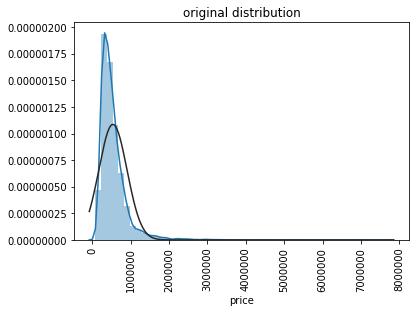

In [6]:
pyplot.title('original distribution')
seaborn.distplot(price, fit=stats.norm)
pyplot.xticks(rotation=90)
print('kurtosis:', price.kurtosis())
print('skew:', price.skew())

Fro the histogram above it can be infered that `price` has [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution).

kurtosis: 0.691857220794
skew: 0.428076514957


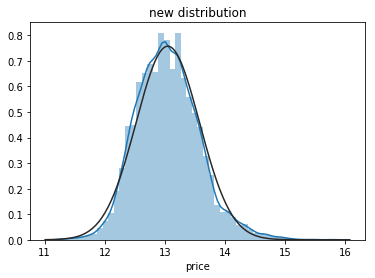

In [7]:
log_price = numpy.log1p(price)
seaborn.distplot(log_price, fit=stats.norm)
pyplot.title('new distribution')
print('kurtosis:', log_price.kurtosis())
print('skew:', log_price.skew())

In [8]:
df['price'] = log_price

## Irelevant Features Drop and Subset Selection

Constant features are irelevant.

In [9]:
# constant features
constant = df.columns[~(df != df.iloc[0]).any()].tolist()
print('constant features:', ', '.join(constant))

constant features: has_sqft_living, has_sqft_lot, has_sqft_above, has_sqft_living15, has_sqft_lot15, has_sqft_all


There is a stange set of features ending with '2', '15', '152'. As shown bellow their are highly correlated. There I think they are probably infered one from each other and I would drop them.

In [10]:
to_drop = df.filter(regex='(2|15|152)$', axis=1).columns.tolist()
to_drop

['sqft_living15',
 'sqft_lot15',
 'sqft_living2',
 'sqft_lot2',
 'sqft_above2',
 'sqft_basement2',
 'has_sqft_living15',
 'sqft_living152',
 'has_sqft_lot15',
 'sqft_lot152',
 'sqft_all2']

In [11]:
# these are probably somehow related
df[df.filter(regex='^sqft_living', axis=1).columns.tolist()].corr(method='pearson')

,sqft_living,sqft_living15,sqft_living2,sqft_living152
sqft_living,1.000000,0.756420,0.987746,0.748607
sqft_living15,0.756420,1.000000,0.756974,0.994109
sqft_living2,0.987746,0.756974,1.000000,0.757893
sqft_living152,0.748607,0.994109,0.757893,1.000000


In [12]:
df[df.filter(regex='^sqft_lot', axis=1).columns.tolist()].corr(method='pearson')

,sqft_lot,sqft_lot15,sqft_lot2,sqft_lot152
sqft_lot,1.000000,0.718557,0.899933,0.696331
sqft_lot15,0.718557,1.000000,0.770809,0.925140
sqft_lot2,0.899933,0.770809,1.000000,0.859910
sqft_lot152,0.696331,0.925140,0.859910,1.000000


In [13]:
df[df.filter(regex='^sqft_above', axis=1).columns.tolist()].corr(method='pearson')

,sqft_above,sqft_above2
sqft_above,1.000000,0.990104
sqft_above2,0.990104,1.000000


In [14]:
df[df.filter(regex='^sqft_basement', axis=1).columns.tolist()].corr(method='pearson')

,sqft_basement,sqft_basement2
sqft_basement,1.000000,0.962298
sqft_basement2,0.962298,1.000000


In [15]:
df[df.filter(regex='^sqft_all', axis=1).columns.tolist()].corr(method='pearson')

,sqft_all,sqft_all2
sqft_all,1.000000,0.930968
sqft_all2,0.930968,1.000000


In [16]:
(df['has_sqft_living15'] == df['has_sqft_living']).all(), (df['has_sqft_lot15'] == df['has_sqft_lot']).all()

(True, True)

`yr_renovated` is mostly 0 and therefore it is not usefull

In [17]:
(df == 0).sum().nlargest()

waterfront           21450
yr_renovated         20699
view                 19489
sqft_basement        13126
has_sqft_basement    13126
dtype: int64

Drop uncorrelated features so that only there is small subset of relevant features.

In [18]:
pearson = df.corr(method='pearson')
not_correlated = pearson[pearson['price'].abs() < 0.1].index.tolist()
print('almost not correlated features:', ', '.join(not_correlated))

almost not correlated features: Unnamed: 0, id, sqft_lot, condition, yr_built, zipcode, long, sqft_lot15, rcprice, has_wine_bar, garage_type


In [19]:
# drop features
df.drop(['id', 'Unnamed: 0', 'date', 'yr_renovated', 'has_sqft_basement'] + constant + to_drop + not_correlated,
        axis=1, inplace=True, errors='ignore')
df.columns.size

12

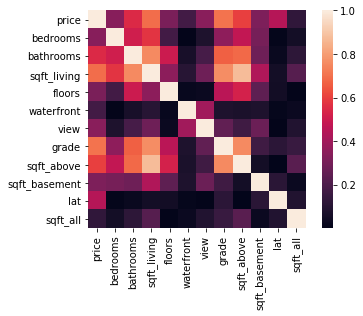

In [20]:
pearson = df.corr(method='pearson')
seaborn.heatmap(pearson.abs(), square=True)

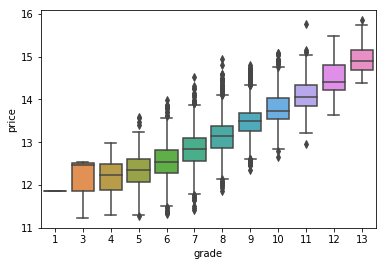

In [21]:
# grade will be good fearute
_ = seaborn.boxplot(x='grade', y='price', data=df)

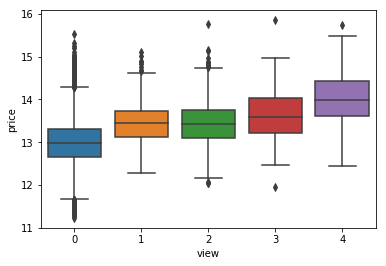

In [22]:
# view somewhat correlated to price
_ = seaborn.boxplot(x='view', y='price', data=df)

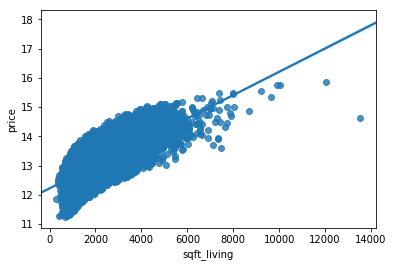

In [23]:
# visible correlation
_ = seaborn.regplot(x='sqft_living', y='price', data=df)

## Train and Test Split

In [24]:
train, test = model_selection.train_test_split(df, test_size=0.25)
print('train:', len(train))
print('test:', len(test))

train: 16209
test: 5404


In [25]:
columns = df.columns.drop('price').tolist()
y_tr = train['price'].as_matrix()
X_tr = train[columns].as_matrix()
y_te = test['price'].as_matrix()
X_te = test[columns].as_matrix()
columns

['bedrooms',
 'bathrooms',
 'sqft_living',
 'floors',
 'waterfront',
 'view',
 'grade',
 'sqft_above',
 'sqft_basement',
 'lat',
 'sqft_all']

## Feature Transformations

Tranformation of all features to zero mean and unit variance.

In [26]:
scaler = preprocessing.StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_te_scaled = scaler.transform(X_te)
X_tr_scaled.mean(axis=0), X_tr_scaled.std(axis=0)

(array([  1.97482573e-16,  -4.99733925e-17,  -1.81591911e-16,
          1.75345237e-18,  -1.07398958e-17,   3.68224997e-17,
         -2.53154686e-16,  -1.18796398e-16,  -5.96173805e-17,
         -2.00805365e-14,   5.12884818e-17]),
 array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]))

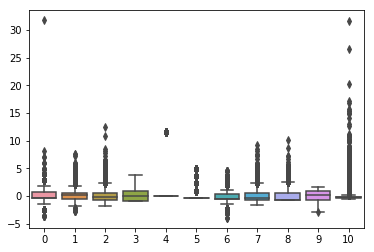

In [27]:
_ = seaborn.boxplot(data=X_tr_scaled)

## Linear Regression

Train and evaluate linear regression with scaling and without scaling. In conclusion there is almost no difference.

root mean squared logarithmic error: 0.27262298552


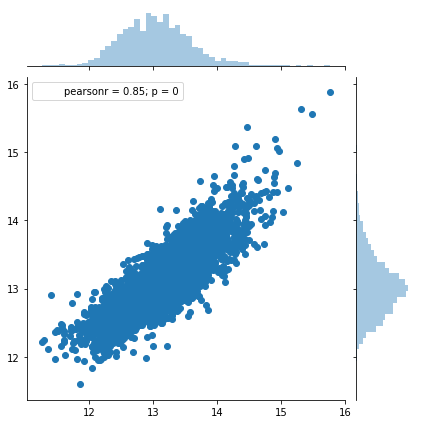

In [28]:
# scaled features
clf = linear_model.LinearRegression()
clf.fit(X_tr_scaled, y_tr)
y_pred = clf.predict(X_te_scaled)

seaborn.jointplot(y_te, y_pred)

rmsle = numpy.sqrt(metrics.mean_squared_error(y_pred, y_te))
print('root mean squared logarithmic error:', rmsle)

root mean squared logarithmic error: 0.272642250438


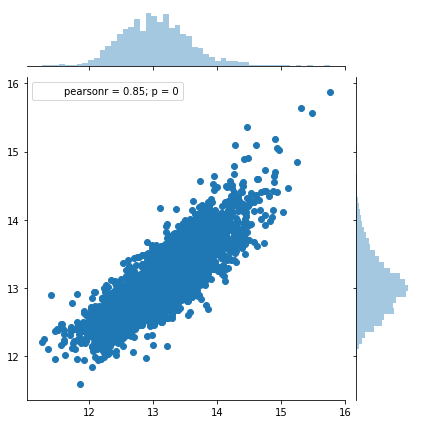

In [29]:
# raw features
clf = linear_model.LinearRegression()
clf.fit(X_tr, y_tr)
y_pred = clf.predict(X_te)

seaborn.jointplot(y_te, y_pred)

rmsle = numpy.sqrt(metrics.mean_squared_error(y_pred, y_te))
print('root mean squared logarithmic error:', rmsle)